<a href="https://colab.research.google.com/github/PJZoio/DocProduct/blob/master/Iterative_ANN_(FTIR_NIR)_com_regularizacao_Inference_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
import pickle
import matplotlib.pyplot as plt
from google.colab import files
import io

In [2]:
# Load the dataset
uploaded = files.upload()

Saving Simples - Espetros Ureia.csv to Simples - Espetros Ureia.csv


In [3]:
data = pd.read_csv(io.BytesIO(uploaded['Simples - Espetros Ureia.csv']), delimiter=';', encoding='latin-1')
print(data)

    Unnamed: 0  Unnamed: 1  Unnamed: 2   Conc    12497,1   12495,17  \
0    Ureia 1#1         NaN         NaN    6,4  0,3183408  0,3186091   
1    Ureia 1#2         NaN         NaN    6,4  0,3177791   0,316333   
2    Ureia 1#3         NaN         NaN    6,4  0,3179853  0,3181079   
3    Ureia 1#4         NaN         NaN    6,4  0,3184242  0,3178834   
4    Ureia 1#5         NaN         NaN    6,4  0,3186918  0,3178618   
..         ...         ...         ...    ...        ...        ...   
90  Ureia 20#1         NaN         NaN  198,4  0,3094258  0,3094288   
91  Ureia 20#2         NaN         NaN  198,4  0,3111292    0,31175   
92  Ureia 20#3         NaN         NaN  198,4  0,3083915  0,3099102   
93  Ureia 20#4         NaN         NaN  198,4  0,3116439  0,3113417   
94  Ureia 20#5         NaN         NaN  198,4  0,3106277   0,310831   

     12493,24   12491,31   12489,38   12487,46  ...     4017,2   4015,271  \
0   0,3188009  0,3183431  0,3179455  0,3178158  ...  0,6469211  0,6275

In [4]:
# Replace commas with periods in numeric columns
for column in data.columns:
  # Check if the column data type is 'object' (likely string) before applying str methods
   if data[column].dtype == 'object':
    # Try converting the column to numeric, errors='coerce' will replace invalid values with NaN
    data[column] = pd.to_numeric(data[column].str.replace(',', '.'), errors='coerce')
    # Now fill NaN values with 0. This is a simple choice, consider other imputation strategies if necessary
    data[column] = data[column].fillna(0)

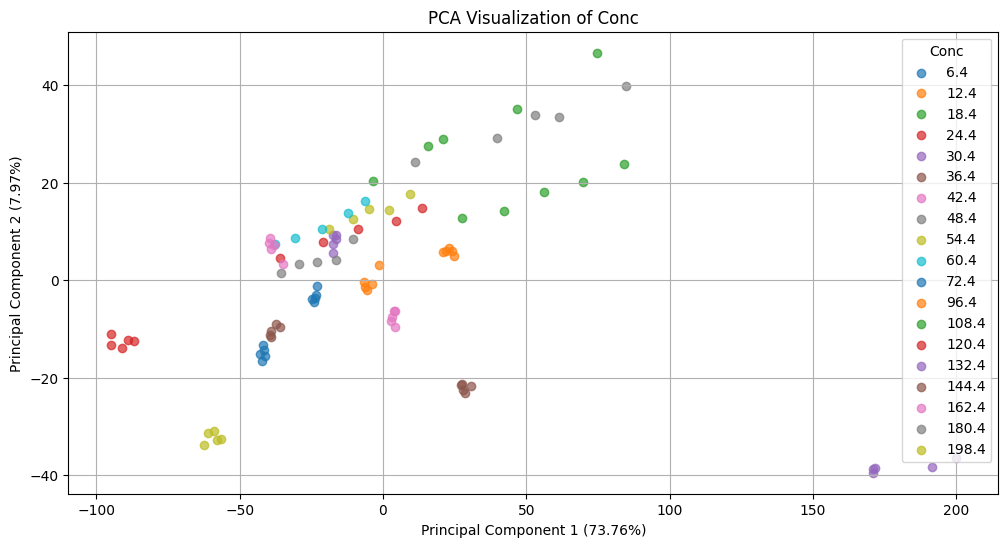

ANN Regression on Selected Wavelengths: R2 = 0.7532, RMSE = 24.2908, Hidden Layers = (100,)


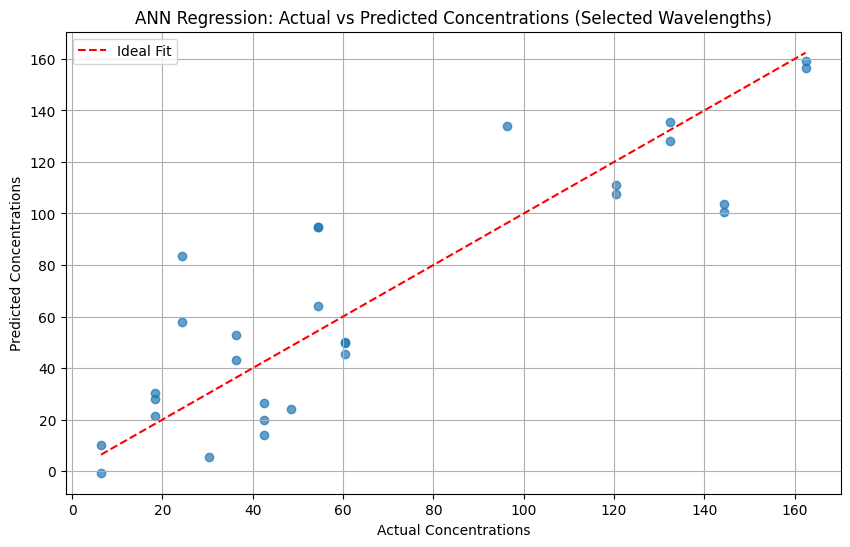

R2 Score: 0.7532
RMSE: 24.2908


In [6]:
# Extract the target and feature columns
target = data['Conc']
features = data.iloc[:, 4:]  # Assuming wavelength data starts at column E

# Function to evaluate a band with ANN and Ridge regularization
def evaluate_band_ann_ridge(start_col, end_col, hidden_layer_sizes=(100,), max_iter=1000, alpha=0.01):
    # Select features within the current band
    band_features = features.iloc[:, start_col:start_col + end_col]
    X_train, X_test, y_train, y_test = train_test_split(band_features, target, test_size=0.3, random_state=42)

    # Normalize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the features BEFORE PCA
    features_scaled = scaler.fit_transform(features) # This line was moved up

    # Perform PCA
    pca = PCA(n_components=2)  # Use 2 components for visualization
    pca_components = pca.fit_transform(features_scaled)

    # Calculate explained variance percentages
    explained_variance = pca.explained_variance_ratio_ * 100

    # Create a DataFrame for visualization
    pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
    pca_df['Conc'] = target.values

    # Visualization of PCA results
    plt.figure(figsize=(12, 6))
    for label in pca_df['Conc'].unique():
        subset = pca_df[pca_df['Conc'] == label]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=label, alpha=0.7)

    plt.title('PCA Visualization of Conc')
    plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f}%)')
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f}%)')
    plt.legend(title='Conc')
    plt.grid(True)
    plt.show()

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

    # Fit the ANN model with L2 regularization (alpha is the regularization strength)
    ann = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, alpha=alpha, random_state=42)
    ann.fit(X_train_scaled, y_train)

    # Predict and calculate R2
    y_pred = ann.predict(X_test_scaled).flatten()
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))


    print(f"ANN Regression on Selected Wavelengths: R2 = {r2:.4f}, RMSE = {rmse:.4f}, Hidden Layers = {hidden_layer_sizes}")

    # Plot actual vs predicted concentrations
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Concentrations')
    plt.ylabel('Predicted Concentrations')
    plt.title('ANN Regression: Actual vs Predicted Concentrations (Selected Wavelengths)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return pca_df, explained_variance, ann, scaler, r2, rmse

# Example usage: Manually select wavelengths from column 10 to 60
start_col = 1
end_col = 4407
pca_df, explained_variance, ann_model, scaler, r2, rmse = evaluate_band_ann_ridge(start_col, end_col, alpha=0.01)

# Print the ANN model performance
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

ANN Regression on Full Spectrum: R2 = 0.6281, RMSE = 889.2871, Hidden Layers = (100,)


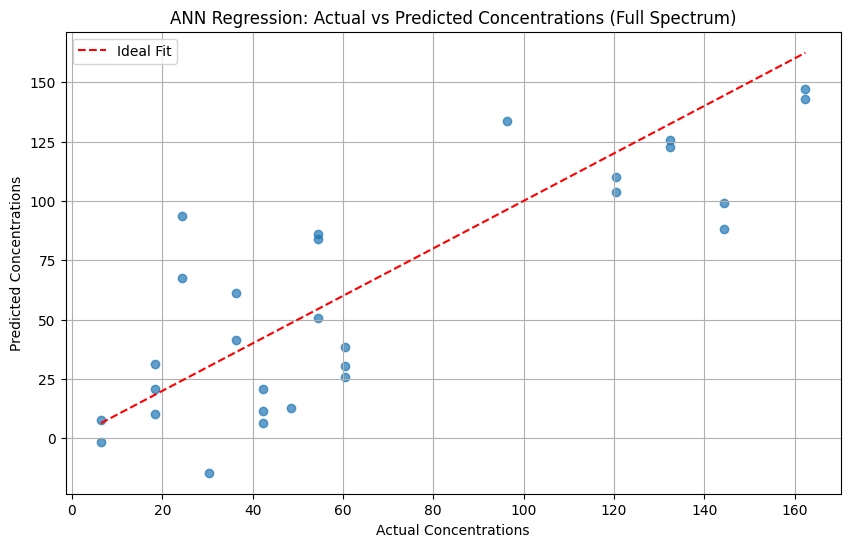

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


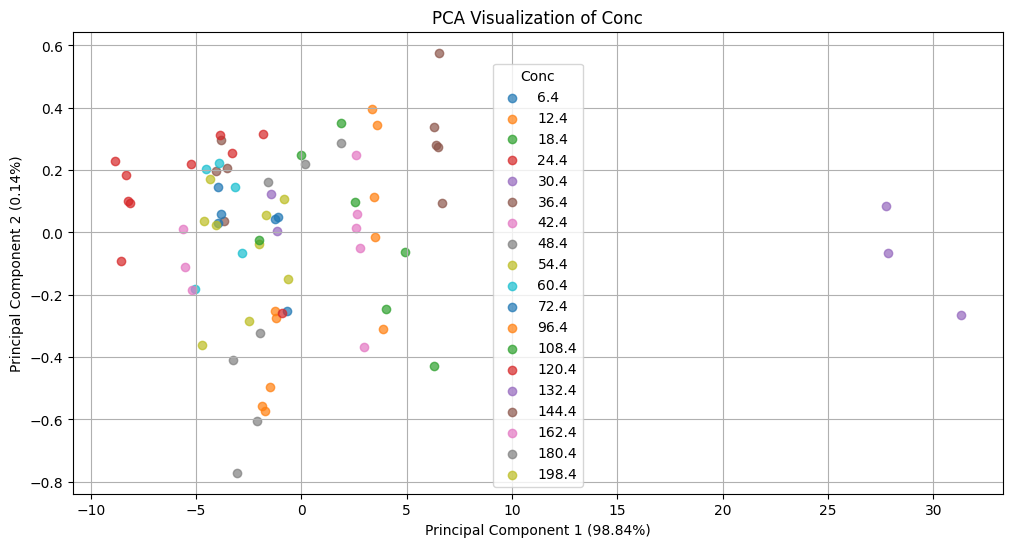

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


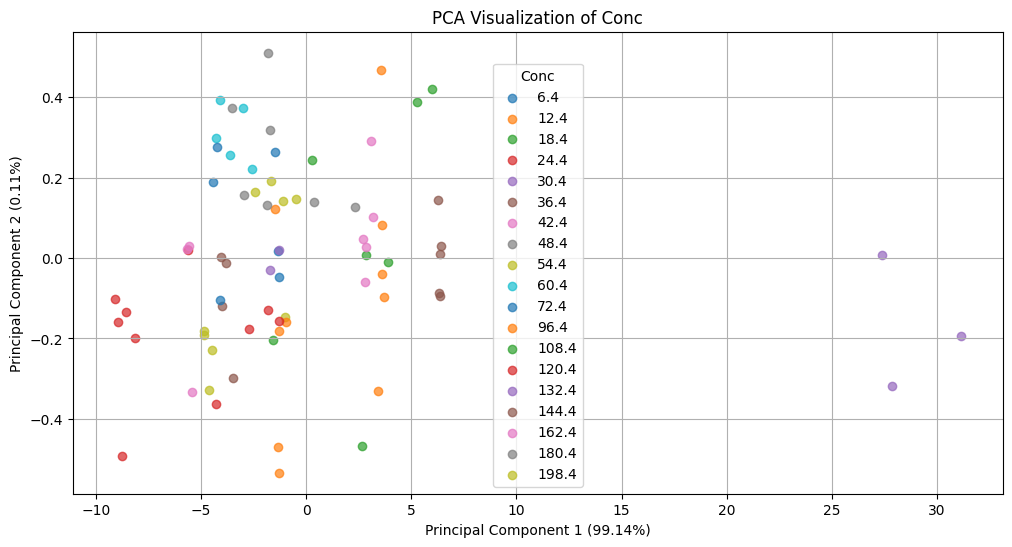

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


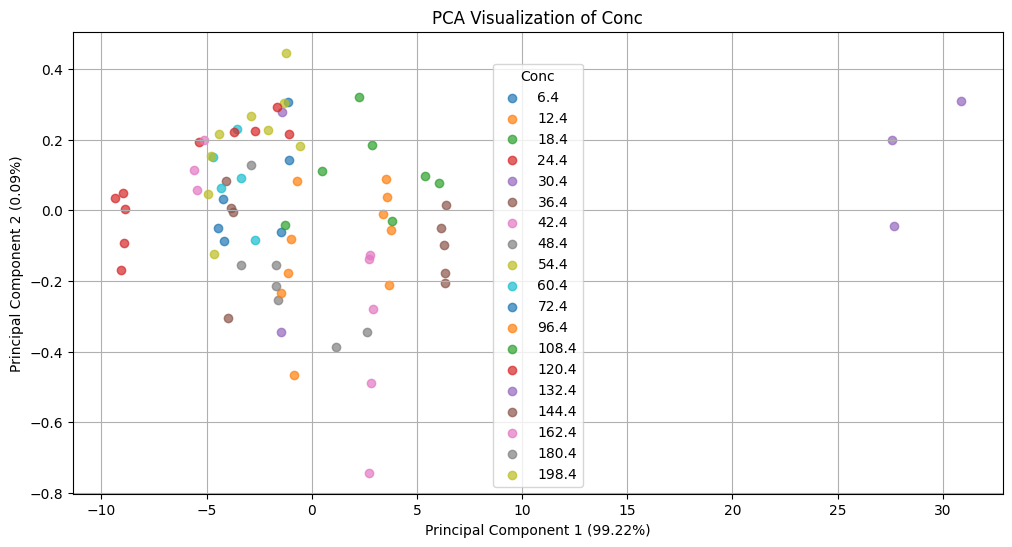

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

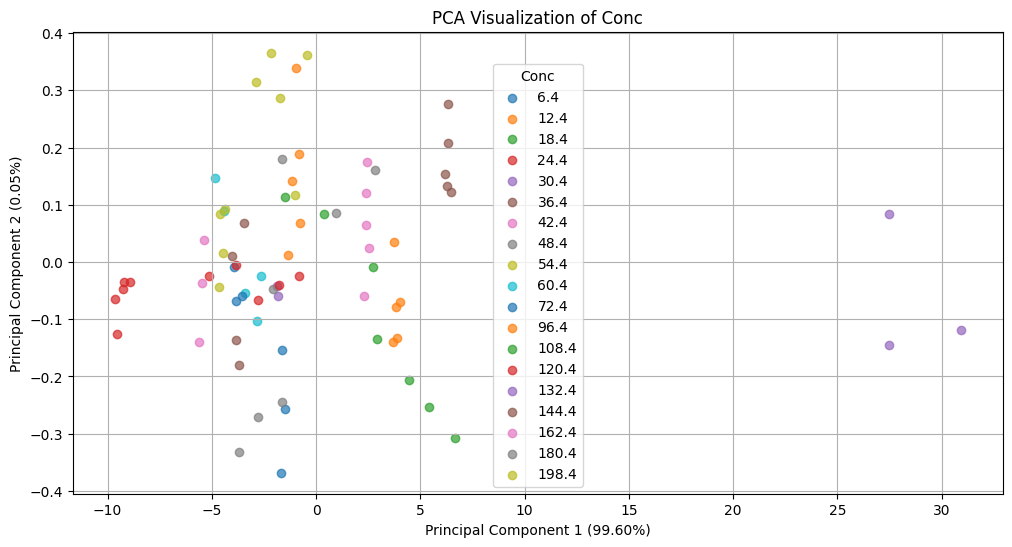

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

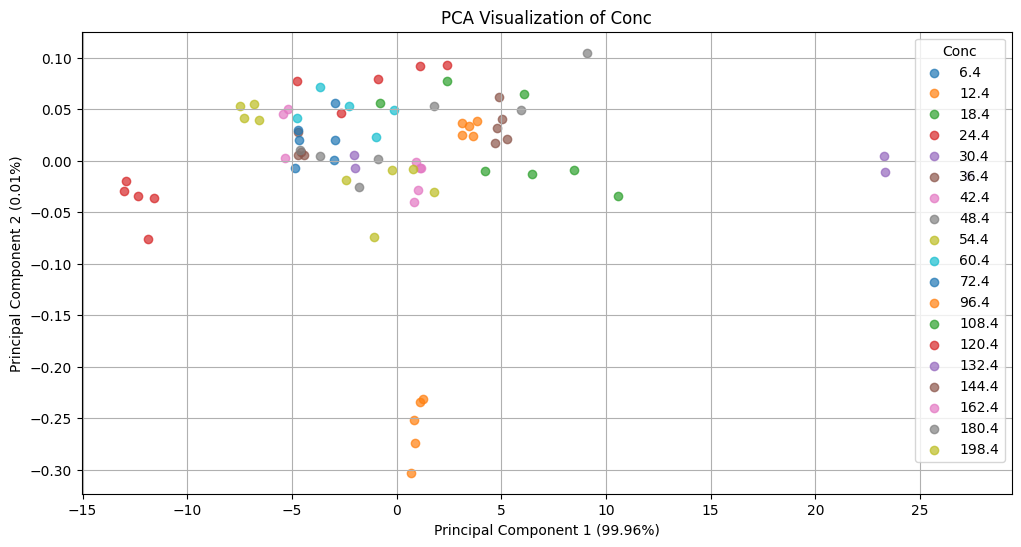

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


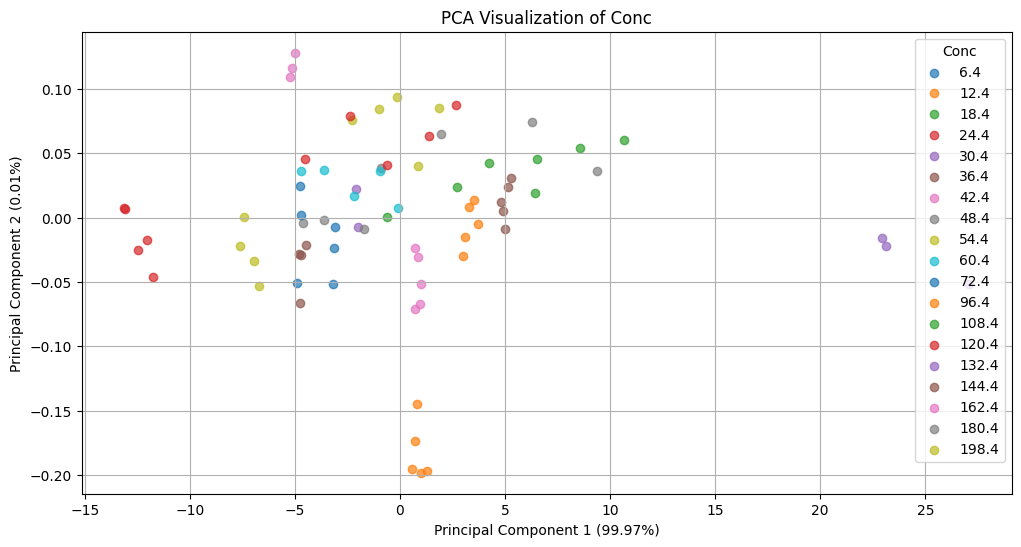

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

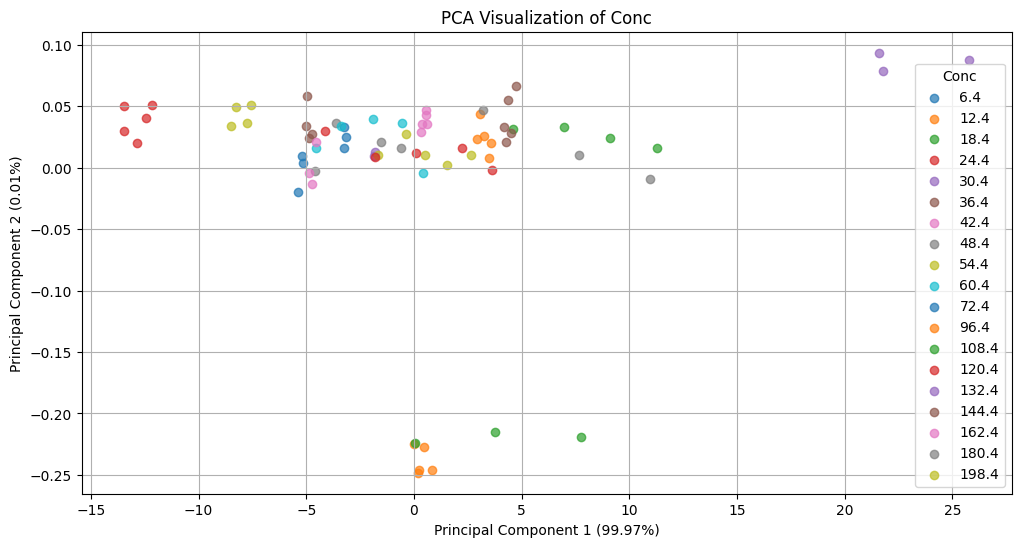

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


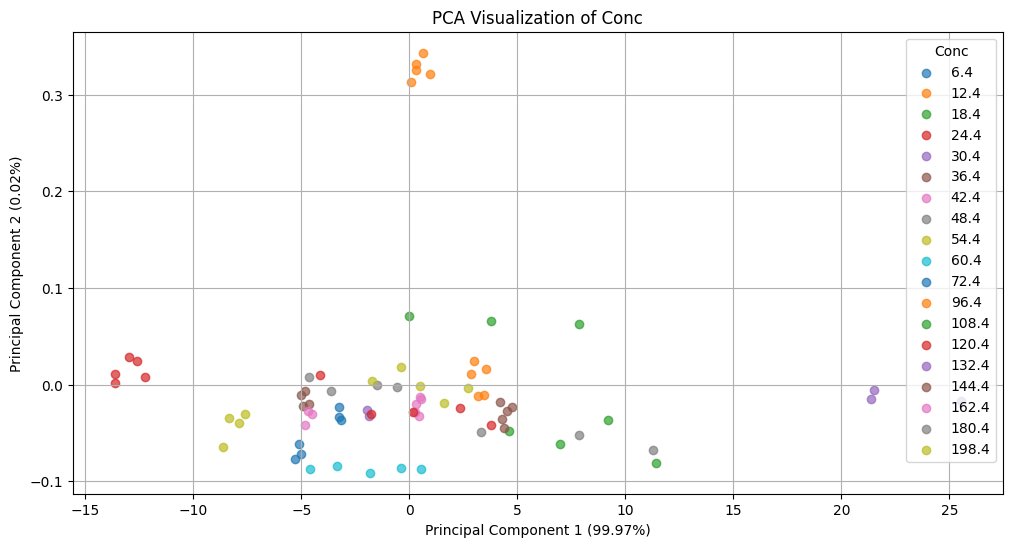

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


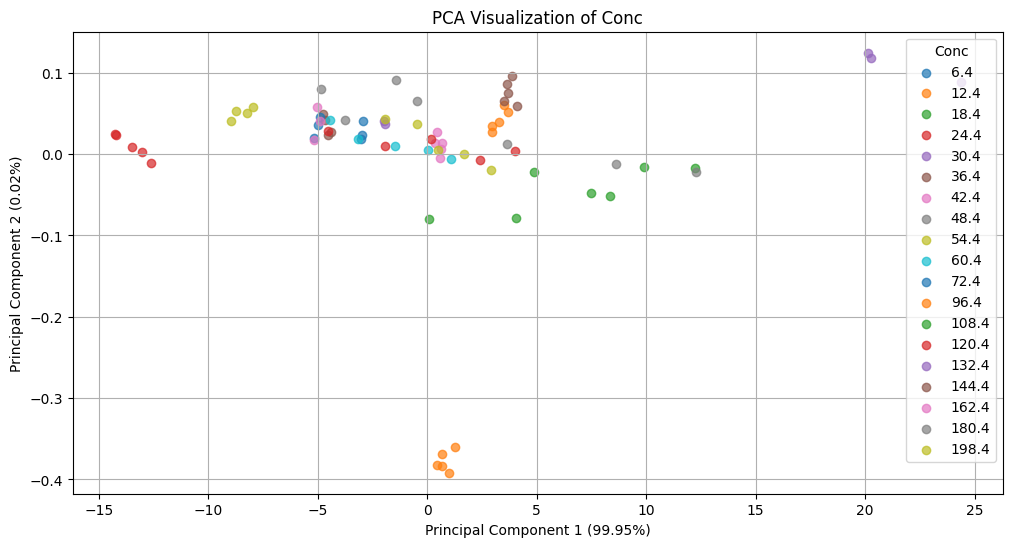

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


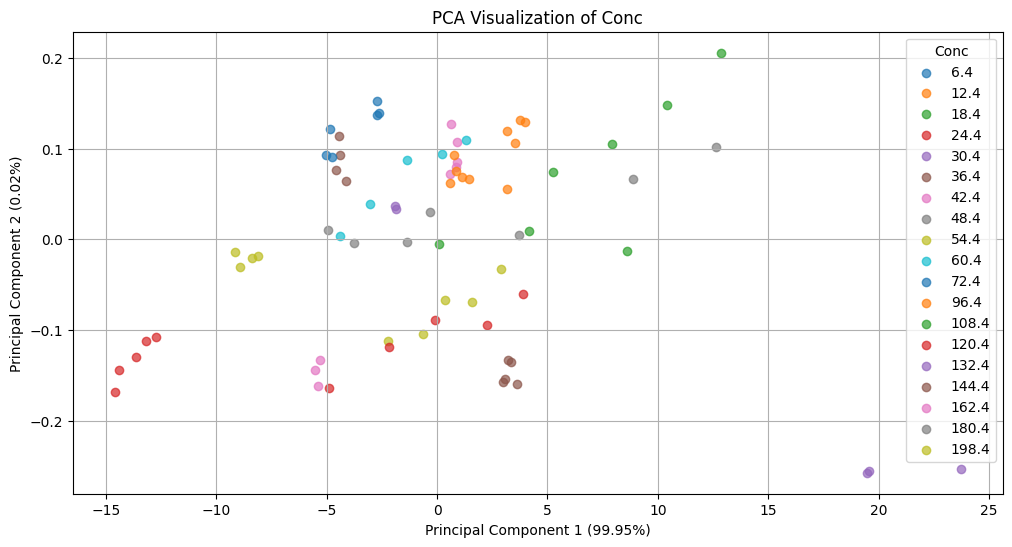

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


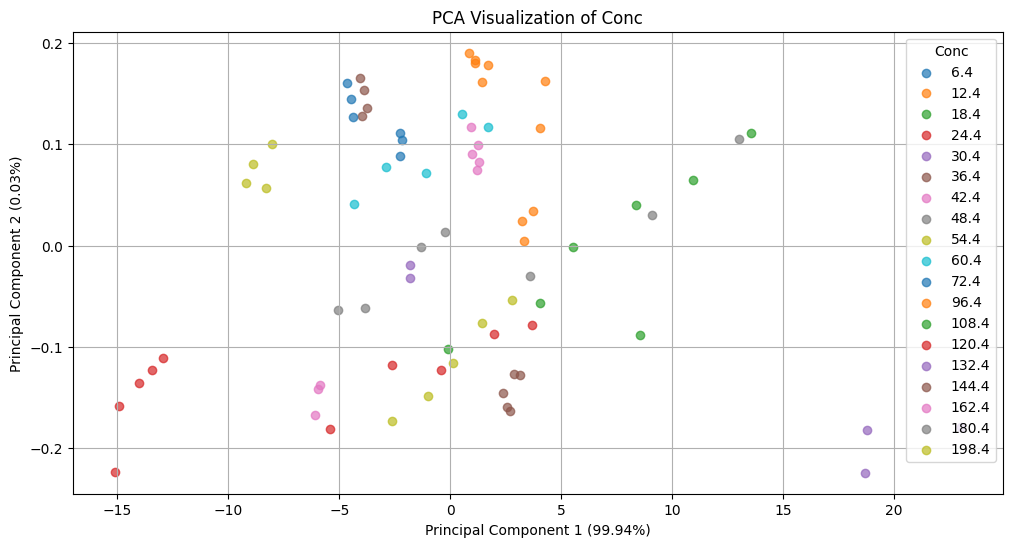

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


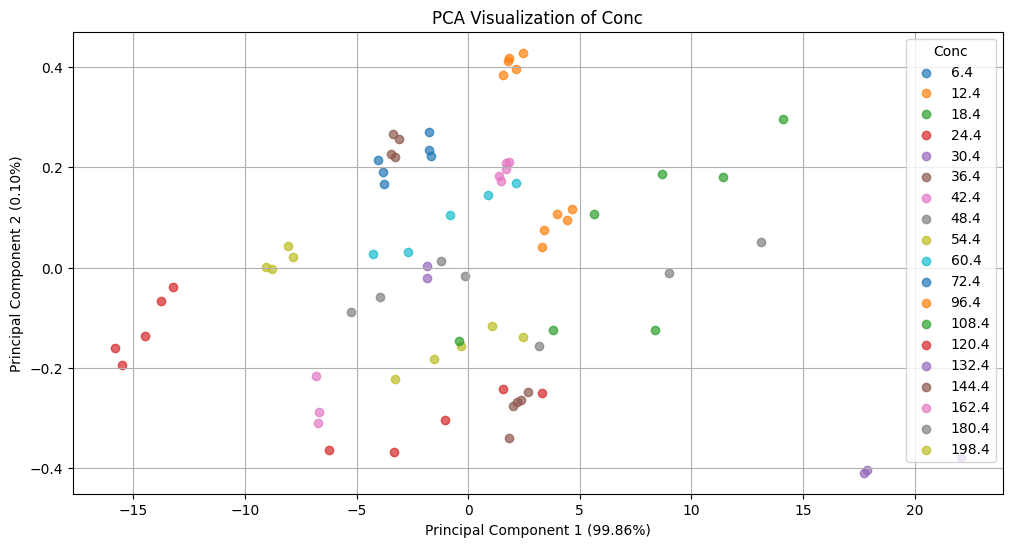

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


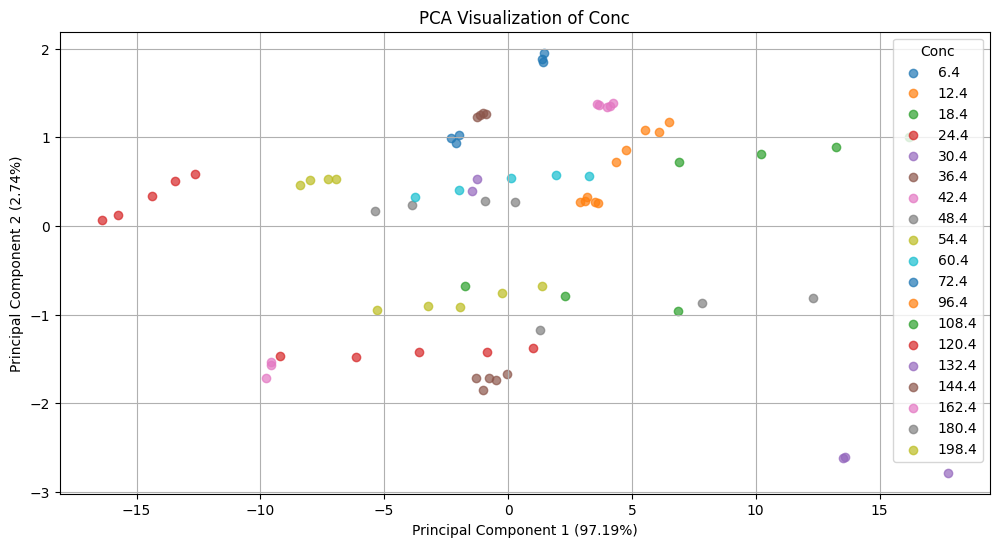

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

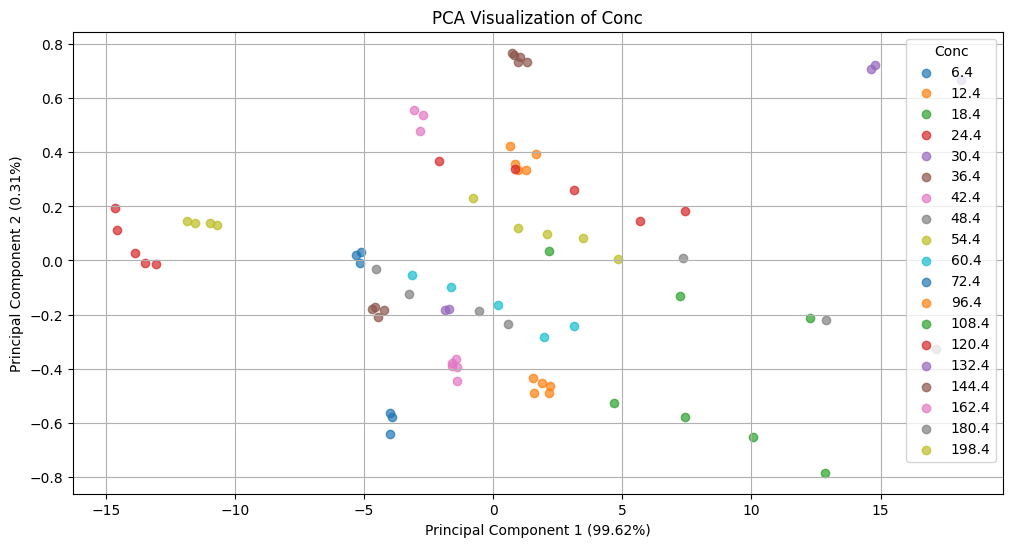

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


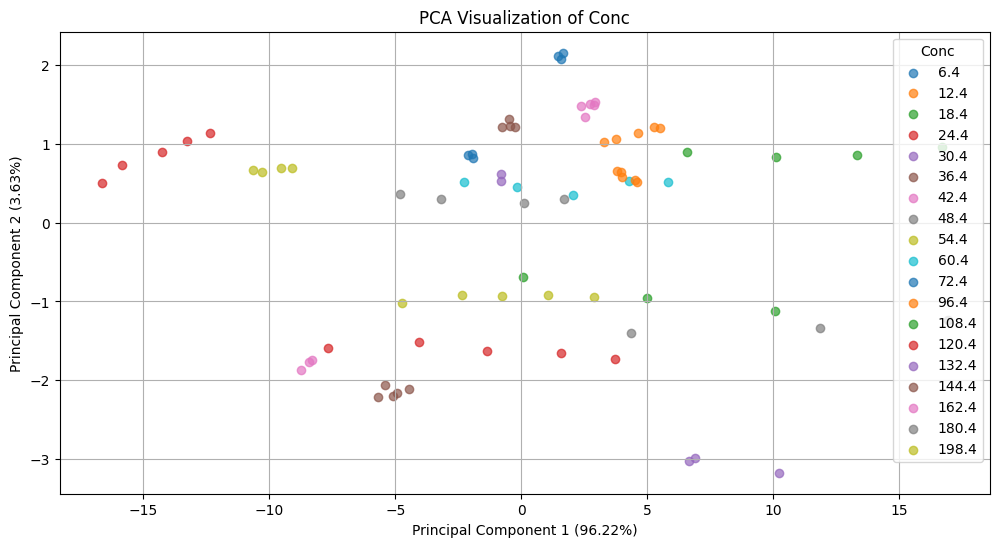

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

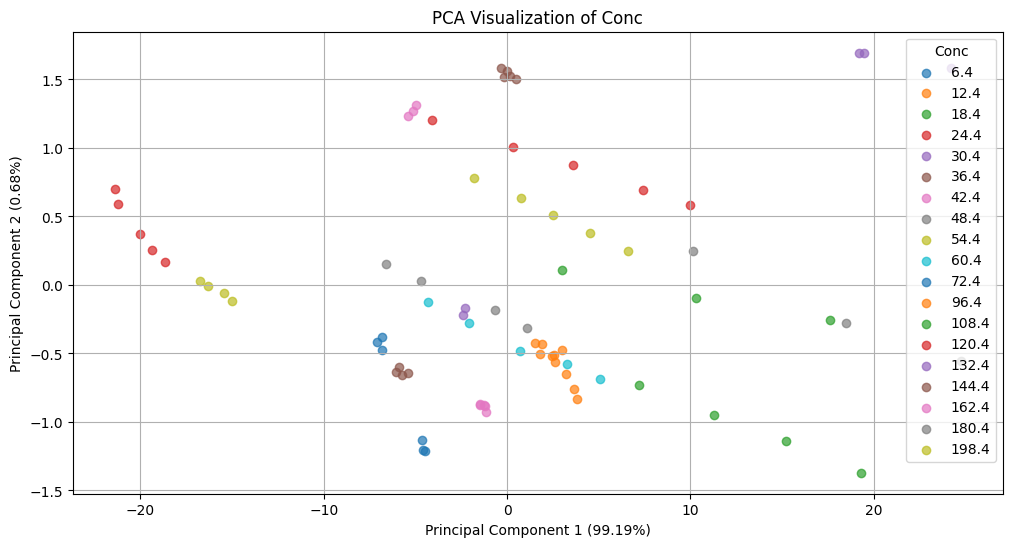

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


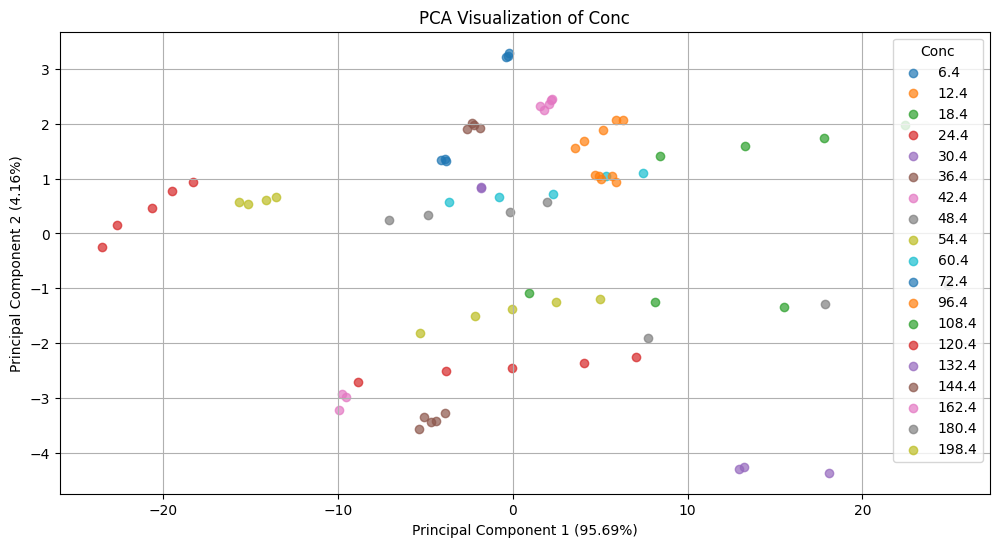

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

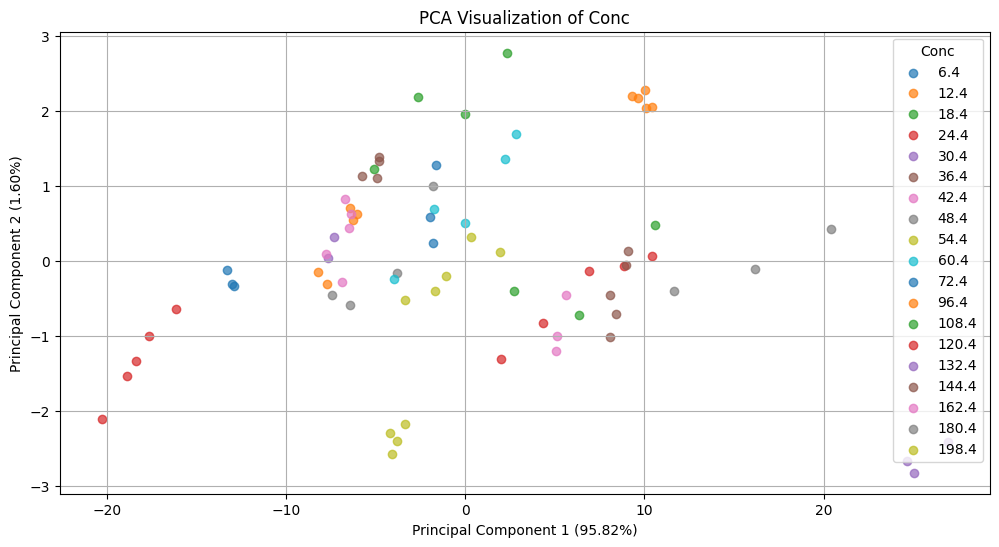

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perce

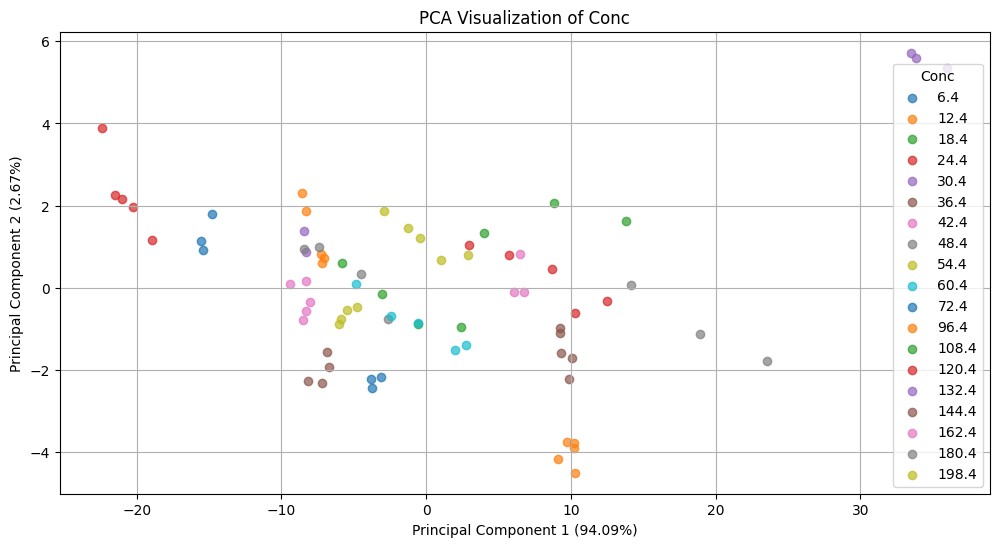

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Band: Start Column = 4050, Width = 150, R2 = 0.7182331515902909, RMSE = 33.97404376519203


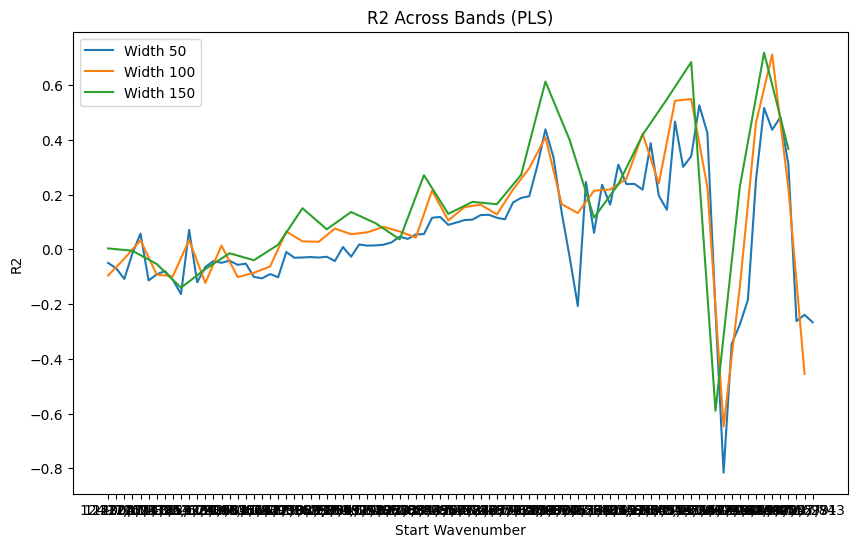

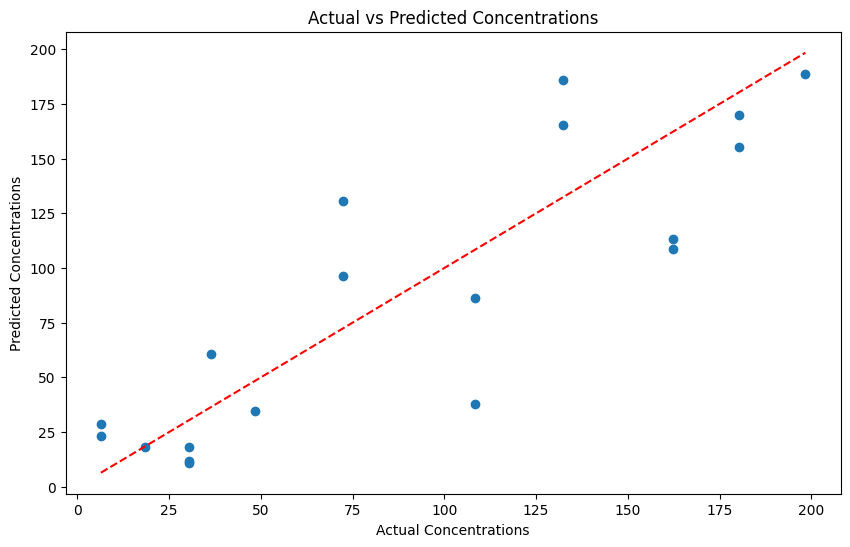

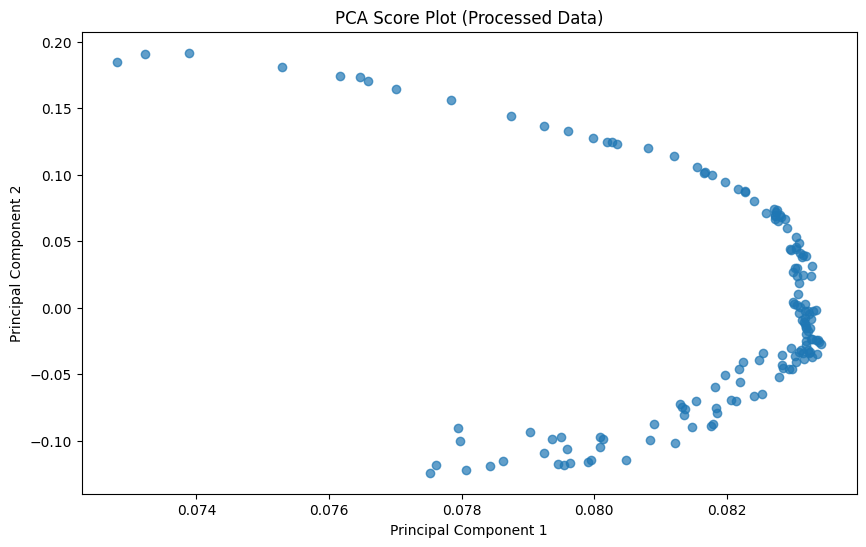

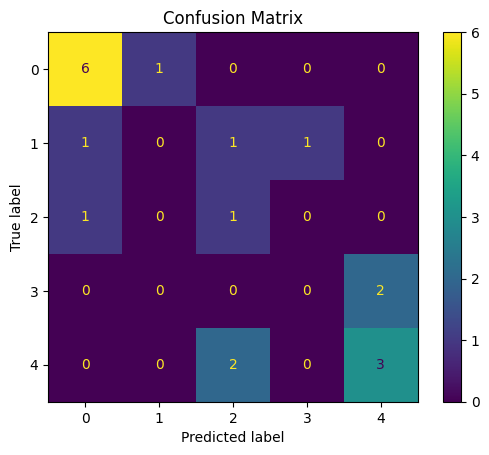

In [7]:
# Function to perform PCA and return explained variance ratio and components
#def apply_pca(data, n_components=None):
    #pca = PCA(n_components=n_components)
    #transformed_data = pca.fit_transform(data)
    #explained_variance = pca.explained_variance_ratio_.sum()
    #return transformed_data, explained_variance, pca

    # ANN Regression on the whole spectrum
hidden_layer_sizes = (100,)
max_iter = 1000
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

ann = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)
ann.fit(X_train, y_train)

# Predict and calculate metrics
y_pred = ann.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"ANN Regression on Full Spectrum: R2 = {r2:.4f}, RMSE = {rmse:.4f}, Hidden Layers = {hidden_layer_sizes}")

# Plot actual vs predicted concentrations
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Concentrations')
plt.ylabel('Predicted Concentrations')
plt.title('ANN Regression: Actual vs Predicted Concentrations (Full Spectrum)')
plt.legend()
plt.grid(True)
plt.show()

# Function to evaluate a band with ANN
def evaluate_band_ann(start_col, band_width, hidden_layer_sizes=(100,), max_iter=1000, n_splits=5):
    band_features = features.iloc[:, start_col:start_col + band_width]

    # Select features within the current band
    band_features = features.iloc[:, start_col:start_col + band_width]
    X_train, X_test, y_train, y_test = train_test_split(band_features, target, test_size=0.3, random_state=42)

    # PCA before preprocessing
    #pca_band_features, explained_variance_pre, raw_pca = apply_pca(band_features)

    #X_train, X_test, y_train, y_test = train_test_split(pca_band_features, target, test_size=0.3, random_state=42)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_r2_scores = []
    fold_rmses = []

    for train_index, test_index in kf.split(band_features):
        X_train, X_test = band_features.iloc[train_index], band_features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Normalize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA to the scaled training data
    pca = PCA(n_components=3) # Adjust n_components as needed
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled) # Transform the test data using the same PCA object

    # Fit the ANN model
    ann = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=42)
    ann.fit(X_train_pca, y_train)

    # Predict and calculate R2
    y_pred = ann.predict(X_test_pca).flatten()
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Calculate RMSE manually

    return r2_score(y_test, y_pred), y_test, y_pred, X_train_scaled, scaler, ann, rmse, X_train, y_train # Return y_test and y_pred

# Iteratively evaluate bands
band_widths = [50, 100, 150]  # Define possible band widths
best_r2 = -np.inf
best_band = None
results = []
best_y_test = None # Initialize best_y_test
best_y_pred = None # Initialize best_y_pred
best_pca_model = None # Initialize best_pca_model
best_pca_explained_variance_ratio_ = None # Initialize best_pca_explained_variance_ratio_
best_scaler = None  # Initialize best_scaler outside the loop
best_X_train = None # Initialize best_X_train to store the training data for the best band
best_y_train = None # Initialize best_y_train to store the training target for the best band
best_ann_model = None # Initialize best_ann_model outside the loop to store the best model

for band_width in band_widths:
    for start_col in range(0, features.shape[1] - band_width + 1, band_width):  # Slide over features
        r2, y_test, y_pred, X_train_scaled, scaler, ann, rmse, X_train, y_train = evaluate_band_ann(start_col, band_width) # Receive rmse from the function call
        results.append({'start_col': start_col, 'band_width': band_width, 'R2': r2, 'RMSE': rmse})
        if r2 > best_r2:
            best_r2 = r2
            best_band = (start_col, band_width)
            best_y_test = y_test # Store y_test for the best band
            best_y_pred = y_pred # Store y_pred for the best band
            best_scaler = scaler # Store the scaler for the best band
            best_X_train = X_train # Store X_train for the best band
            best_y_train = y_train # Store y_train for the best band

            # Store the best ANN model
            best_ann_model = ann  # Assign the current 'pls' to 'best_pls_model'

            # Fit PCA on the best band features
            pca = PCA(n_components=3)  # Adjust n_components as needed
            best_pca_model = pca.fit(scaler.fit_transform(best_X_train)) # Fit PCA to the scaled training data
            best_pca_explained_variance_ratio_ = best_pca_model.explained_variance_ratio_ #Store explained variance ratio

            # Add the PCA components to the dataframe for visualization
            pca_components = best_pca_model.transform(scaler.transform(best_X_train))  # Get PCA components from the scaled data
            pca_df = pd.DataFrame(pca_components[:, :2], columns=['PCA1', 'PCA2']) # Select the first 2 components
            pca_df['Conc'] = best_y_train.values  # Add the corresponding target values (y_train)

            # Calculate explained variance percentages
            best_pca_explained_variance_ratio_ = best_pca_model.explained_variance_ratio_ * 100

            # Visualization of PCA results
            plt.figure(figsize=(12, 6))
            for label in pca_df['Conc'].unique():
                subset = pca_df[pca_df['Conc'] == label]
                plt.scatter(subset['PCA1'], subset['PCA2'], label=label, alpha=0.7)

            plt.title('PCA Visualization of Conc')
            plt.xlabel(f'Principal Component 1 ({best_pca_explained_variance_ratio_[0]:.2f}%)')
            plt.ylabel(f'Principal Component 2 ({best_pca_explained_variance_ratio_[1]:.2f}%)')
            plt.legend(title='Conc')
            plt.grid(True)
            plt.show()

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Display the best band
print(f"Best Band: Start Column = {best_band[0]}, Width = {best_band[1]}, R2 = {best_r2}, RMSE = {results_df.loc[results_df['R2'].idxmax(), 'RMSE']}") # Access RMSE from results_df

# Visualization (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for band_width in band_widths:
    subset = results_df[results_df['band_width'] == band_width]
    start_wavenumbers = [features.columns[i] for i in subset['start_col']]
    plt.plot(start_wavenumbers, subset['R2'], label=f'Width {band_width}')
plt.xlabel('Start Wavenumber')
plt.ylabel('R2')
plt.legend()
plt.title('R2 Across Bands (PLS)')
plt.show()

# Plot actual vs predicted concentrations
plt.figure(figsize=(10, 6))
plt.scatter(best_y_test, best_y_pred)
plt.plot([best_y_test.min(), best_y_test.max()], [best_y_test.min(), best_y_test.max()], 'r--')
plt.xlabel('Actual Concentrations')
plt.ylabel('Predicted Concentrations')
plt.title('Actual vs Predicted Concentrations')
plt.show()

# Visualize PCA components - Raw data
#plt.figure(figsize=(10, 6))
#plt.scatter(best_raw_pca.components_[0], best_raw_pca.components_[1], alpha=0.7)
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
#plt.title('PCA Score Plot (Raw Data)')
#plt.show()

# Visualize PCA components- Processed data
plt.figure(figsize=(10, 6))
plt.scatter(best_pca_model.components_[0], best_pca_model.components_[1], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Score Plot (Processed Data)')
plt.show()

# Adjust confusion matrix for multi-class (use bins for classification)
num_bins = 5  # Example: categorize concentrations into 5 bins
# Get unique values for bins
unique_values = np.unique(np.concatenate((best_y_test, best_y_pred)))

# If unique values are less than num_bins, adjust num_bins
num_bins = min(num_bins, len(unique_values))

# Ensure at least 2 bins for the confusion matrix
num_bins = max(num_bins, 5)
y_test_bins = pd.cut(best_y_test, bins=num_bins, labels=False)
y_pred_bins = pd.cut(best_y_pred, bins=num_bins, labels=False)
conf_matrix = confusion_matrix(y_test_bins, y_pred_bins)
display_labels = np.arange(num_bins)
ConfusionMatrixDisplay(conf_matrix, display_labels=display_labels).plot()
plt.title(f"Confusion Matrix")
plt.show()



In [8]:
# Save the best model using the captured best_pls and best_scaler
with open('best_ann_model.pkl', 'wb') as file:
    pickle.dump((best_ann_model, best_scaler, best_band), file)

In [9]:
loaded_model = pickle.load(open('best_ann_model.pkl','rb'))

In [10]:
uploaded = files.upload()

Saving Sol compostas (ureia)_inferencia.csv to Sol compostas (ureia)_inferencia.csv


In [11]:
# Load new dataset for inference
inference_data = pd.read_csv('Sol compostas (ureia)_inferencia.csv', delimiter=';', encoding='latin-1')

Inference completed. Results saved to 'inference_results.csv'.


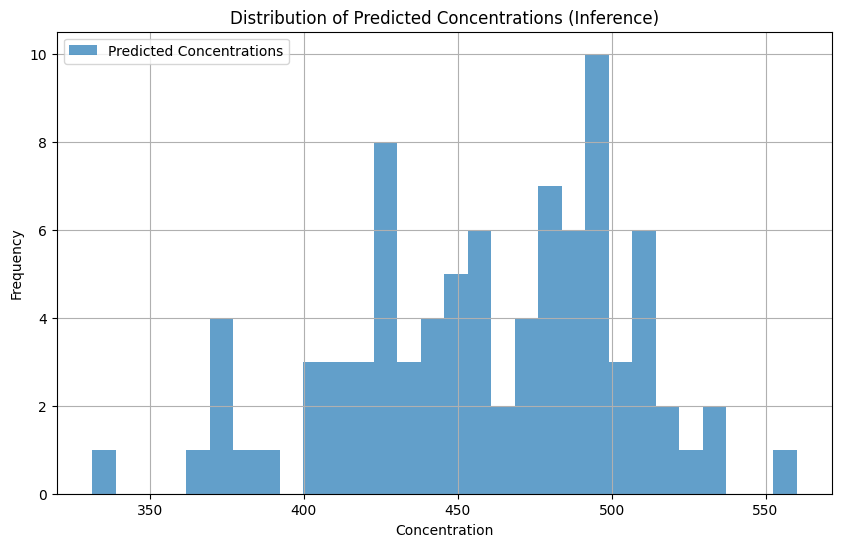

In [12]:
# Replace commas with periods in numeric columns
for column in inference_data.columns:
    if inference_data[column].dtype == 'object':
        inference_data[column] = pd.to_numeric(inference_data[column].str.replace(',', '.'), errors='coerce').fillna(0)

# Extract features and reduce to the best band
inference_features = inference_data.iloc[:, 4:]
band_start, band_width = best_band

# Align inference features with training features
training_columns = features.columns[band_start:band_start + band_width]
inference_band = inference_features.reindex(columns=training_columns, fill_value=0)

# Ensure band_start and band_width are within the bounds of inference_features
#band_start = min(band_start, inference_features.shape[1] - 1)
#band_width = min(band_width, inference_features.shape[1] - band_start)

#inference_band = inference_features.iloc[:, band_start:band_start + band_width]

# Convert inference_band columns to numeric if necessary
#for column in inference_band.columns:
    #if inference_band[column].dtype == 'object':  # Check if the column data type is 'object'
        #inference_band[column] = pd.to_numeric(inference_band[column].str.replace(',', '.'), errors='coerce').fillna(0)

# Get the column names used during training for the best band
#training_band_columns = features.columns[best_band[0]:best_band[0] + best_band[1]]

# Ensure inference_band has the same column names as training data
#inference_band = inference_band.reindex(columns=training_band_columns, fill_value=0)

# Preprocess inference data
inference_scaled = best_scaler.transform(inference_band)

# Apply PCA transformation using the loaded PCA model
inference_pca = best_pca_model.transform(inference_scaled) # This line is added

# Perform prediction
predicted_conc = loaded_model[0].predict(inference_pca).flatten()

# Append predictions to the dataset
inference_data = pd.concat([inference_data, pd.DataFrame({'Predicted_Conc': predicted_conc})], axis=1)

# Save the resulting dataset
inference_data.to_csv('inference_results.csv', index=False, sep=';')
print("Inference completed. Results saved to 'inference_results.csv'.")

# Plot inference data distribution
plt.figure(figsize=(10, 6))
plt.hist(predicted_conc, bins=30, alpha=0.7, label='Predicted Concentrations')
plt.title('Distribution of Predicted Concentrations (Inference)')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
files.download('inference_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>